In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from collections import OrderedDict
from tqdm import tqdm
import datetime

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(644),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(644),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(644),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'D:/Data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val' , 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_sizes

{'train': 4560, 'val': 385, 'test': 570}

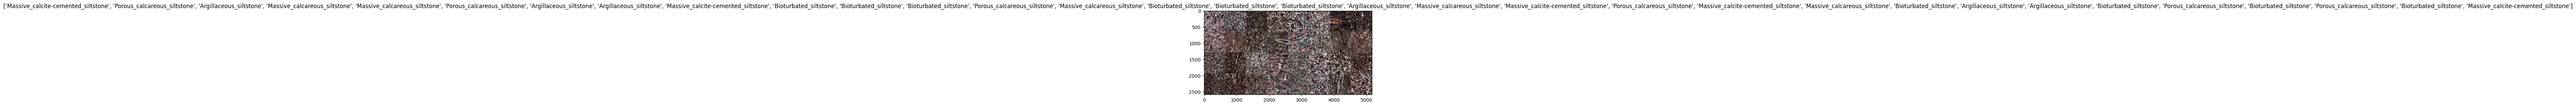

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            print(datetime.datetime.now())

            # Each epoch has a training and validation phase
            for phase in ['train', 'val', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [7]:
model_ft = models.mobilenet_v3_large(weights='IMAGENET1K_V2', pretrained=True)
num_ftrs = model_ft.classifier[3].out_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (1): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (2): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine

In [9]:
model_ft

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [10]:
#for name, param in model_ft.named_parameters():
#    param.requires_grad = False

In [12]:
for name, param in model_ft.named_parameters():
    if param.requires_grad:
        print(f"{name} will be updated.")
    else:
        print(f"{name} will not be updated.")

features.0.0.weight will be updated.
features.0.1.weight will be updated.
features.0.1.bias will be updated.
features.1.block.0.0.weight will be updated.
features.1.block.0.1.weight will be updated.
features.1.block.0.1.bias will be updated.
features.1.block.1.0.weight will be updated.
features.1.block.1.1.weight will be updated.
features.1.block.1.1.bias will be updated.
features.2.block.0.0.weight will be updated.
features.2.block.0.1.weight will be updated.
features.2.block.0.1.bias will be updated.
features.2.block.1.0.weight will be updated.
features.2.block.1.1.weight will be updated.
features.2.block.1.1.bias will be updated.
features.2.block.2.0.weight will be updated.
features.2.block.2.1.weight will be updated.
features.2.block.2.1.bias will be updated.
features.3.block.0.0.weight will be updated.
features.3.block.0.1.weight will be updated.
features.3.block.0.1.bias will be updated.
features.3.block.1.0.weight will be updated.
features.3.block.1.1.weight will be updated.
fea

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
2024-09-29 14:42:56.597597


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:04:36<00:00, 27.11s/it]


train Loss: 0.6356 Acc: 0.8465


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:39<00:00,  7.65s/it]


val Loss: 1.2151 Acc: 0.7351


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:19<00:00,  7.76s/it]


test Loss: 1.0763 Acc: 0.7702

Epoch 1/29
----------
2024-09-29 15:51:32.395003


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:03:35<00:00, 26.68s/it]


train Loss: 0.0498 Acc: 0.9827


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:33<00:00,  7.17s/it]


val Loss: 0.1490 Acc: 0.9584


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:17<00:00,  7.64s/it]


test Loss: 0.2289 Acc: 0.9509

Epoch 2/29
----------
2024-09-29 16:58:58.230775


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:03:33<00:00, 26.67s/it]


train Loss: 0.0204 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:32<00:00,  7.10s/it]


val Loss: 0.1134 Acc: 0.9610


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:12<00:00,  7.35s/it]


test Loss: 0.2425 Acc: 0.9474

Epoch 3/29
----------
2024-09-29 18:06:16.590557


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:02:32<00:00, 26.24s/it]


train Loss: 0.0147 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:25<00:00,  6.60s/it]


val Loss: 0.2510 Acc: 0.9195


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:06<00:00,  7.02s/it]


test Loss: 0.2618 Acc: 0.9456

Epoch 4/29
----------
2024-09-29 19:12:21.243950


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:00:50<00:00, 25.53s/it]


train Loss: 0.0100 Acc: 0.9974


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:34<00:00,  7.25s/it]


val Loss: 0.1929 Acc: 0.9429


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:10<00:00,  7.25s/it]


test Loss: 0.2729 Acc: 0.9579

Epoch 5/29
----------
2024-09-29 20:16:56.540659


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:00:53<00:00, 25.55s/it]


train Loss: 0.0056 Acc: 0.9989


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:26<00:00,  6.67s/it]


val Loss: 0.1450 Acc: 0.9506


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:02<00:00,  6.81s/it]


test Loss: 0.3254 Acc: 0.9421

Epoch 6/29
----------
2024-09-29 21:21:19.910511


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:03:49<00:00, 26.78s/it]


train Loss: 0.0118 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:29<00:00,  6.89s/it]


val Loss: 0.1966 Acc: 0.9429


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:09<00:00,  7.20s/it]


test Loss: 0.2154 Acc: 0.9649

Epoch 7/29
----------
2024-09-29 22:28:48.696108


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:03:14<00:00, 26.54s/it]


train Loss: 0.0020 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:32<00:00,  7.12s/it]


val Loss: 0.1915 Acc: 0.9455


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:14<00:00,  7.46s/it]


test Loss: 0.2156 Acc: 0.9632

Epoch 8/29
----------
2024-09-29 23:35:50.475371


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:02:09<00:00, 26.08s/it]


train Loss: 0.0017 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:33<00:00,  7.16s/it]


val Loss: 0.1919 Acc: 0.9429


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:09<00:00,  7.21s/it]


test Loss: 0.2254 Acc: 0.9596

Epoch 9/29
----------
2024-09-30 00:41:42.446734


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:01:04<00:00, 25.62s/it]


train Loss: 0.0011 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:29<00:00,  6.90s/it]


val Loss: 0.1866 Acc: 0.9455


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:06<00:00,  7.02s/it]


test Loss: 0.2276 Acc: 0.9579

Epoch 10/29
----------
2024-09-30 01:46:22.697255


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:02:17<00:00, 26.14s/it]


train Loss: 0.0010 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:36<00:00,  7.43s/it]


val Loss: 0.1742 Acc: 0.9532


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:12<00:00,  7.39s/it]


test Loss: 0.2302 Acc: 0.9649

Epoch 11/29
----------
2024-09-30 02:52:29.770728


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:01:08<00:00, 25.65s/it]


train Loss: 0.0016 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:27<00:00,  6.73s/it]


val Loss: 0.1725 Acc: 0.9532


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:02<00:00,  6.78s/it]


test Loss: 0.2218 Acc: 0.9737

Epoch 12/29
----------
2024-09-30 03:57:07.476377


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:00:10<00:00, 25.25s/it]


train Loss: 0.0008 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:26<00:00,  6.63s/it]


val Loss: 0.1798 Acc: 0.9532


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:02<00:00,  6.82s/it]


test Loss: 0.2271 Acc: 0.9684

Epoch 13/29
----------
2024-09-30 05:00:46.646192


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:01:10<00:00, 25.67s/it]


train Loss: 0.0014 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:32<00:00,  7.12s/it]


val Loss: 0.2088 Acc: 0.9351


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:07<00:00,  7.07s/it]


test Loss: 0.2341 Acc: 0.9632

Epoch 14/29
----------
2024-09-30 06:05:37.128854


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:02:52<00:00, 26.38s/it]


train Loss: 0.0008 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:35<00:00,  7.32s/it]


val Loss: 0.2054 Acc: 0.9351


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:10<00:00,  7.26s/it]


test Loss: 0.2353 Acc: 0.9614

Epoch 15/29
----------
2024-09-30 07:12:15.754601


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:00:39<00:00, 25.45s/it]


train Loss: 0.0009 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:33<00:00,  7.22s/it]


val Loss: 0.2059 Acc: 0.9351


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:11<00:00,  7.31s/it]


test Loss: 0.2341 Acc: 0.9632

Epoch 16/29
----------
2024-09-30 08:16:40.991508


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:01:20<00:00, 25.74s/it]


train Loss: 0.0009 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:32<00:00,  7.11s/it]


val Loss: 0.2089 Acc: 0.9377


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:09<00:00,  7.18s/it]


test Loss: 0.2350 Acc: 0.9614

Epoch 17/29
----------
2024-09-30 09:21:43.800160


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:02:23<00:00, 26.18s/it]


train Loss: 0.0008 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:29<00:00,  6.89s/it]


val Loss: 0.2036 Acc: 0.9377


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:05<00:00,  6.95s/it]


test Loss: 0.2359 Acc: 0.9632

Epoch 18/29
----------
2024-09-30 10:27:42.368719


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:03:49<00:00, 26.78s/it]


train Loss: 0.0009 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:28<00:00,  6.78s/it]


val Loss: 0.2009 Acc: 0.9377


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:09<00:00,  7.22s/it]


test Loss: 0.2359 Acc: 0.9632

Epoch 19/29
----------
2024-09-30 11:35:09.707125


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:02:12<00:00, 26.10s/it]


train Loss: 0.0012 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:26<00:00,  6.64s/it]


val Loss: 0.1952 Acc: 0.9403


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:04<00:00,  6.92s/it]


test Loss: 0.2338 Acc: 0.9614

Epoch 20/29
----------
2024-09-30 12:40:53.443735


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:02:52<00:00, 26.38s/it]


train Loss: 0.0005 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:33<00:00,  7.21s/it]


val Loss: 0.1990 Acc: 0.9377


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:16<00:00,  7.56s/it]


test Loss: 0.2346 Acc: 0.9614

Epoch 21/29
----------
2024-09-30 13:47:35.972465


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:03:26<00:00, 26.62s/it]


train Loss: 0.0011 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:39<00:00,  7.66s/it]


val Loss: 0.1987 Acc: 0.9403


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:13<00:00,  7.40s/it]


test Loss: 0.2348 Acc: 0.9632

Epoch 22/29
----------
2024-09-30 14:54:54.960869


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:04:52<00:00, 27.22s/it]


train Loss: 0.0028 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:34<00:00,  7.30s/it]


val Loss: 0.1985 Acc: 0.9377


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:13<00:00,  7.41s/it]


test Loss: 0.2345 Acc: 0.9614

Epoch 23/29
----------
2024-09-30 16:03:36.231654


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:03:24<00:00, 26.61s/it]


train Loss: 0.0014 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:22<00:00,  6.37s/it]


val Loss: 0.2001 Acc: 0.9377


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:59<00:00,  6.63s/it]


test Loss: 0.2348 Acc: 0.9614

Epoch 24/29
----------
2024-09-30 17:10:22.996423


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:01:47<00:00, 25.93s/it]


train Loss: 0.0009 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:26<00:00,  6.68s/it]


val Loss: 0.1957 Acc: 0.9403


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:59<00:00,  6.64s/it]


test Loss: 0.2338 Acc: 0.9632

Epoch 25/29
----------
2024-09-30 18:15:37.359264


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:01:41<00:00, 25.89s/it]


train Loss: 0.0006 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:24<00:00,  6.50s/it]


val Loss: 0.1959 Acc: 0.9403


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:01<00:00,  6.73s/it]


test Loss: 0.2341 Acc: 0.9614

Epoch 26/29
----------
2024-09-30 19:20:44.863227


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:02:24<00:00, 26.19s/it]


train Loss: 0.0007 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:27<00:00,  6.72s/it]


val Loss: 0.1953 Acc: 0.9403


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:11<00:00,  7.33s/it]


test Loss: 0.2335 Acc: 0.9632

Epoch 27/29
----------
2024-09-30 20:26:48.987377


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:02:45<00:00, 26.33s/it]


train Loss: 0.0005 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:27<00:00,  6.73s/it]


val Loss: 0.1946 Acc: 0.9403


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:05<00:00,  6.99s/it]


test Loss: 0.2345 Acc: 0.9632

Epoch 28/29
----------
2024-09-30 21:33:07.813224


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:03:59<00:00, 26.85s/it]


train Loss: 0.0006 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:28<00:00,  6.82s/it]


val Loss: 0.1957 Acc: 0.9403


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:08<00:00,  7.11s/it]


test Loss: 0.2355 Acc: 0.9632

Epoch 29/29
----------
2024-09-30 22:40:44.142948


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:02:38<00:00, 26.28s/it]


train Loss: 0.0008 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:28<00:00,  6.82s/it]


val Loss: 0.1979 Acc: 0.9403


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:03<00:00,  6.85s/it]


test Loss: 0.2377 Acc: 0.9632

Training complete in 1983m 58s
Best val Acc: 0.961039


In [14]:
test_transforms = {
    'test': transforms.Compose([
        transforms.Resize(644),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = 'D:/Data'
test_ds = {x: datasets.ImageFolder(os.path.join(data_dir, x), test_transforms[x])
                  for x in ['test']}
test_dataloader = {x: torch.utils.data.DataLoader(test_ds[x], batch_size=4,
                                             shuffle=False, num_workers=4) for x in ['test']}

def test_model(model, loss_fn, dataloader):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(test_ds['test'])
    correct = 0.0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in test_dataloader['test']:
            X= X.to(device)
            outputs = model(X)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == y.data)

    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%")

test_model(model_ft, criterion, test_dataloader)

Test Error: 
 Accuracy: 94.7%
